In [1]:
# General imports
import os
import sys
import cortex
import numpy as np
import matplotlib.pyplot as plt

# Personals Import 
sys.path.append("{}/../utils".format(os.getcwd()))
from cifti_utils import from_170k_to_59k
from surface_utils import load_surface
from pycortex_utils import get_rois

# load settings
import json
with open('../settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)
formats = analysis_info['formats']
extensions = analysis_info['extensions']

In [2]:
main_dir = '/Users/uriel/disks/meso_shared'
code_dir = '/Users/uriel/disks/meso_H/projects'
project_dir = 'RetinoMaps'
subject = 'sub-01'

_170k_dir_ ='{}/{}/derivatives/fmriprep/fmriprep/{}/ses-01/func/'.format(main_dir,project_dir,subject)
_170k_fn = '{}_ses-01_task-pMF_run-01_space-fsLR_den-170k_bold.dtseries.nii'.format(subject)

mmp_rois_dir = '{}/{}/derivatives/pp_data/cortex/db/sub-170k/'.format(main_dir,project_dir,subject)
mmp_rois_fn = 'mmp_atlas_rois_59k.npz'


In [3]:
# load any 170k data to acces 59k mask 
img_170k, data_170k = load_surface('{}/{}'.format(_170k_dir_,_170k_fn))
rois_dict_59k = dict(np.load('{}/{}'.format(mmp_rois_dir,mmp_rois_fn)))

In [4]:
# Load surface 
surfs = [cortex.polyutils.Surface(*d) for d in cortex.db.get_surf('sub-170k', "flat")]
surf_lh, surf_rh = surfs[0], surfs[1]
lh_vert_num, rh_vert_num = surf_lh.pts.shape[0], surf_rh.pts.shape[0]

In [5]:
# Decompose the 170k datas 
results = from_170k_to_59k(img=img_170k, data=data_170k, return_concat_hemis=False, return_59k_mask=True)
data_59k_L = results['data_L']
data_59k_R = results['data_R']
mask_59k = results['mask_59k']

In [6]:
# Make hemi masks 59k
mask_59k_L = mask_59k[:lh_vert_num]
mask_59k_R = mask_59k[-rh_vert_num:]

In [11]:
#  Make rois dict 
rois_dict_59k_L = {roi: data[:lh_vert_num] for roi, data in rois_dict_59k.items()}
rois_dict_59k_R = {roi: data[-rh_vert_num:] for roi, data in rois_dict_59k.items()}

In [12]:
# Make the final 170k Rois dict 
n_vertrx_170k = data_170k.shape[1]

rois_dict_170k = {}
for key, value in rois_dict_59k.items():
    rois_dict_170k[key] = value[mask_59k]
    vertex_to_add = n_vertrx_170k - len(value[mask_59k])
    rois_dict_170k[key] = np.concatenate((value[mask_59k], np.full(vertex_to_add, False)))
    
    
rois_dict_170k_L = {}
for key, value in rois_dict_59k_L.items():
    rois_dict_170k_L[key] = value[mask_59k_L]
    vertex_to_add = n_vertrx_170k - len(value[mask_59k_L])
    rois_dict_170k_L[key] = np.concatenate((value[mask_59k_L], np.full(vertex_to_add, False)))

rois_dict_170k_R = {}
for key, value in rois_dict_59k_R.items():
    rois_dict_170k_R[key] = value[mask_59k_R]
    vertex_to_add = n_vertrx_170k - (len(value[mask_59k_R])+len(value[mask_59k_L]))
    rois_dict_170k_R[key] = np.concatenate((np.full(len(value[mask_59k_L]), False),value[mask_59k_R], np.full(vertex_to_add, False)))
    
    
    


In [13]:
# Define groups and their corresponding ROIs in a dictionary
groups = {'V1': ['V1'], 
          'V2': ['V2'], 
          'V3': ['V3', 'V4'], 
          'V3AB': ['V3A', 'V3B', 'V3CD'], 
          'LO': ['LO1', 'LO2', 'LO3'], 
          'VO': ['V8', 'PIT', 'PH', 'FFC', 'VMV1', 'VMV2', 'VMV3', 'VVC'], 
          'hMT+': ['V4t', 'MST', 'MT', 'FST'], 
          'iIPS': ['IP0', 'IPS1', 'V7', 'MIP', '7PI', 'IP1', 'V6A'], 
          'sIPS': ['VIP', 'LIPv', 'LIPd', 'IP2', '7PC', 'AIP', '7AL', '7Am', '7Pm'], 
          'iPCS': ['PEF', 'IFJp', '6v', 'IFJa', '55b'], 
          'sPCS': ['FEF', 'i6-8', '6a', '6d', '6mp', '6ma'], 
          'mPCS': ['SCEF', '24dv', 'p32pr', '24dv']}

# Brain 59k group
rois_dict_59k_group = {}
for group_name, rois_keys in groups.items():
    # Create an array of False for the group
    group_array = np.array([False] * len(next(iter(rois_dict_59k.values()))))
    for key in rois_keys:
        if key in rois_dict_59k:  # Check for key existence
            # Combine arrays with logical OR
            group_array = np.logical_or(group_array, rois_dict_59k[key])
    # Add the result under the group key
    rois_dict_59k_group[group_name] = group_array
    
# Left hemisphere 59k group
rois_dict_59k_group_L = {}
for group_name, rois_keys in groups.items():
    # Create an array of False for the group
    group_array = np.array([False] * len(next(iter(rois_dict_59k_L.values()))))
    for key in rois_keys:
        if key in rois_dict_59k_L:  # Check for key existence
            # Combine arrays with logical OR
            group_array = np.logical_or(group_array, rois_dict_59k_L[key])
    # Add the result under the group key
    rois_dict_59k_group_L[group_name] = group_array

# Right hemisphere 59k group 
rois_dict_59k_group_R = {}
for group_name, rois_keys in groups.items():
    # Create an array of False for the group
    group_array = np.array([False] * len(next(iter(rois_dict_59k_R.values()))))
    for key in rois_keys:
        if key in rois_dict_59k_R:  # Check for key existence
            # Combine arrays with logical OR
            group_array = np.logical_or(group_array, rois_dict_59k_R[key])
    # Add the result under the group key
    rois_dict_59k_group_R[group_name] = group_array
    

# Brain 170k group
rois_dict_170k_group = {}
for group_name, rois_keys in groups.items():
    # Create an array of False for the group
    group_array = np.array([False] * len(next(iter(rois_dict_170k.values()))))
    for key in rois_keys:
        if key in rois_dict_170k:  # Check for key existence
            # Combine arrays with logical OR
            group_array = np.logical_or(group_array, rois_dict_170k[key])
    # Add the result under the group key
    rois_dict_170k_group[group_name] = group_array

# Left hemisphere 170k group
rois_dict_170k_group_L = {}
for group_name, rois_keys in groups.items():
    # Create an array of False for the group
    group_array = np.array([False] * len(next(iter(rois_dict_170k_L.values()))))
    for key in rois_keys:
        if key in rois_dict_170k_L:  # Check for key existence
            # Combine arrays with logical OR
            group_array = np.logical_or(group_array, rois_dict_170k_L[key])
    # Add the result under the group key
    rois_dict_170k_group_L[group_name] = group_array

# Right hemisphere 170k group 
rois_dict_170k_group_R = {}
for group_name, rois_keys in groups.items():
    # Create an array of False for the group
    group_array = np.array([False] * len(next(iter(rois_dict_170k_R.values()))))
    for key in rois_keys:
        if key in rois_dict_170k_R:  # Check for key existence
            # Combine arrays with logical OR
            group_array = np.logical_or(group_array, rois_dict_170k_R[key])
    # Add the result under the group key
    rois_dict_170k_group_R[group_name] = group_array

In [14]:
atlas_dir = '{}/{}/analysis_code/atlas'.format(code_dir,project_dir)
os.makedirs(atlas_dir, exist_ok=True)

# Brain 170k 
rois_170k_fn = 'mmp_atlas_rois_170k.npz'
np.savez('{}/{}'.format(atlas_dir,rois_170k_fn), **rois_dict_170k)

# Left hemisphere 170k 
rois_170k_fn_L = 'mmp_atlas_rois_170k_hemi-L.npz'
np.savez('{}/{}'.format(atlas_dir,rois_170k_fn_L), **rois_dict_170k_L)

# Right hemisphere 170k 
rois_170k_fn_R = 'mmp_atlas_rois_170k_hemi-R.npz'
np.savez('{}/{}'.format(atlas_dir,rois_170k_fn_R), **rois_dict_170k_R)

# Brain 59k 
rois_59k_fn = 'mmp_atlas_rois_59k.npz'
np.savez('{}/{}'.format(atlas_dir,rois_59k_fn), **rois_dict_59k)

# Left hemisphere 59k 
rois_59k_fn_L = 'mmp_atlas_rois_59k_hemi-L.npz'
np.savez('{}/{}'.format(atlas_dir,rois_59k_fn_L), **rois_dict_59k_L)

# right hemisphere 59k 
rois_59k_fn_R = 'mmp_atlas_rois_59k_hemi-R.npz'
np.savez('{}/{}'.format(atlas_dir,rois_59k_fn_R), **rois_dict_59k_R)

# Brain 59k group
rois_59k_group_fn = 'mmp_group_atlas_rois_59k.npz'
np.savez('{}/{}'.format(atlas_dir,rois_59k_group_fn), **rois_dict_59k_group)

# Brain 170k group
rois_170k_group_fn = 'mmp_group_atlas_rois_170k.npz'
np.savez('{}/{}'.format(atlas_dir,rois_170k_group_fn), **rois_dict_170k_group)

# Left hemisphere 170k group 
rois_170k_group_fn_L = 'mmp_group_atlas_rois_170k_hemi-L.npz'
np.savez('{}/{}'.format(atlas_dir,rois_170k_group_fn_L), **rois_dict_170k_group_L)

# Right hemisphere 170k group
rois_170k_group_fn_R = 'mmp_group_atlas_rois_170k_hemi-R.npz'
np.savez('{}/{}'.format(atlas_dir,rois_170k_group_fn_R), **rois_dict_170k_group_R)

# left hemisphere 59k group 
rois_59k_group_fn_L = 'mmp_group_atlas_rois_59k_hemi-L.npz'
np.savez('{}/{}'.format(atlas_dir,rois_59k_group_fn_L), **rois_dict_59k_group_L)

# Right hemisphere 59k group 
rois_59k_group_fn_R = 'mmp_group_atlas_rois_59k_hemi-R.npz'
np.savez('{}/{}'.format(atlas_dir,rois_59k_group_fn_R), **rois_dict_59k_group_R)

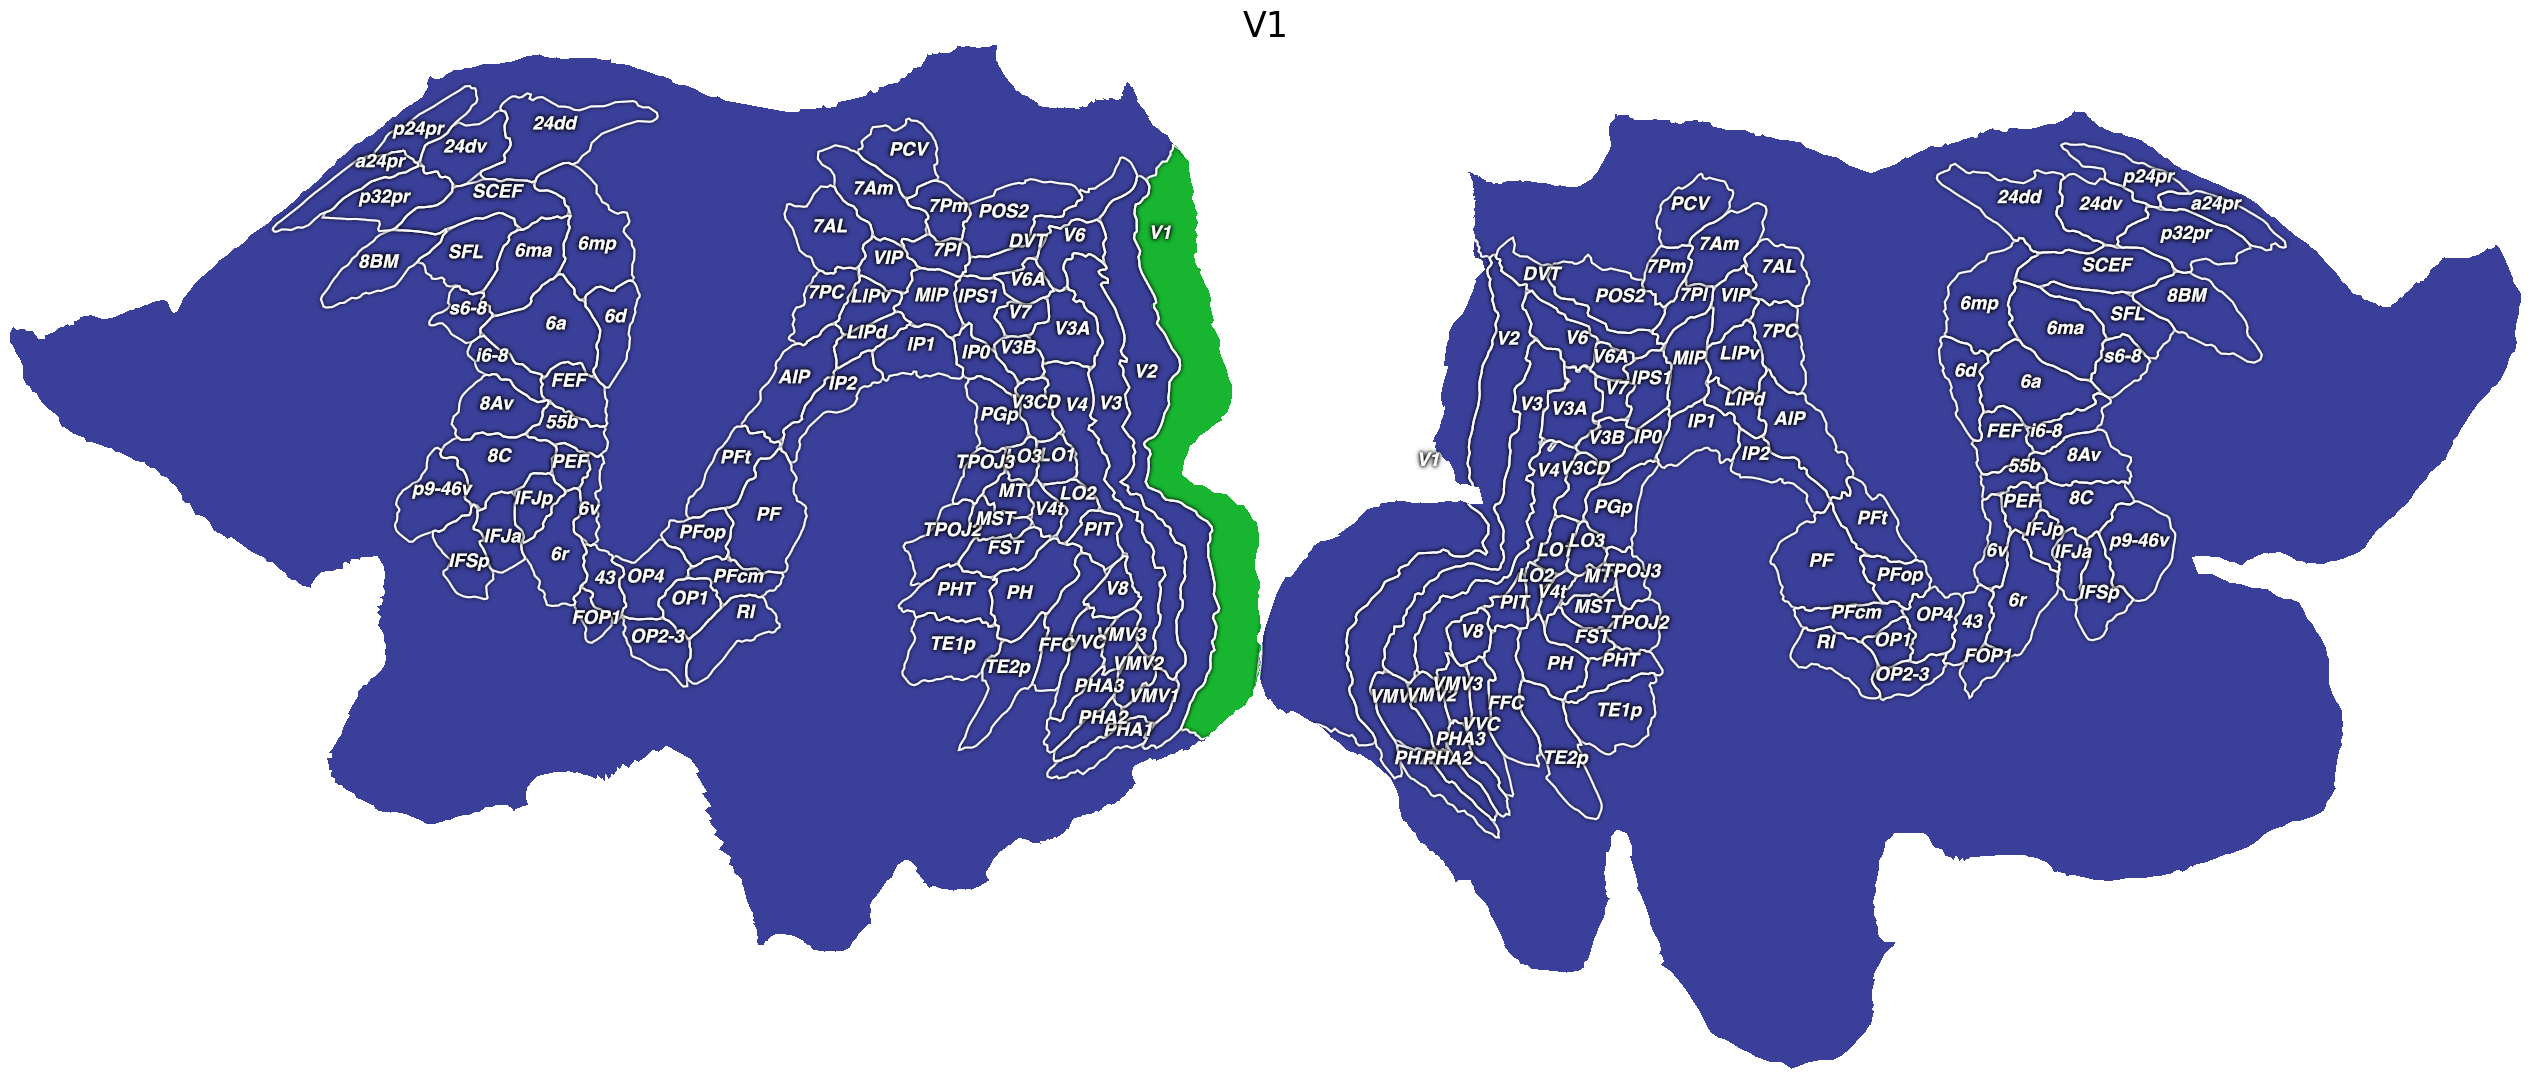

In [9]:
# Make verification with replot areas 
roi_name = 'V1'
pycortex_subject = 'sub-170k'
roi_data = np.array((rois_dict_170k_L[roi_name] == True).astype(np.int32)).reshape((1, rois_dict_170k_L[roi_name].shape[0]))

results = from_170k_to_59k(img=img_170k, data=roi_data, return_concat_hemis=True, return_59k_mask=False)
roi_data_59k = results['data_concat']

vertex_data = cortex.Vertex(roi_data_59k[0,:], pycortex_subject, cmap='BROYG', vmin=0, vmax=1)
cortex.quickshow(vertex_data, with_colorbar=False)
plt.title('{}'.format(roi_name),fontsize=25)
plt.show()

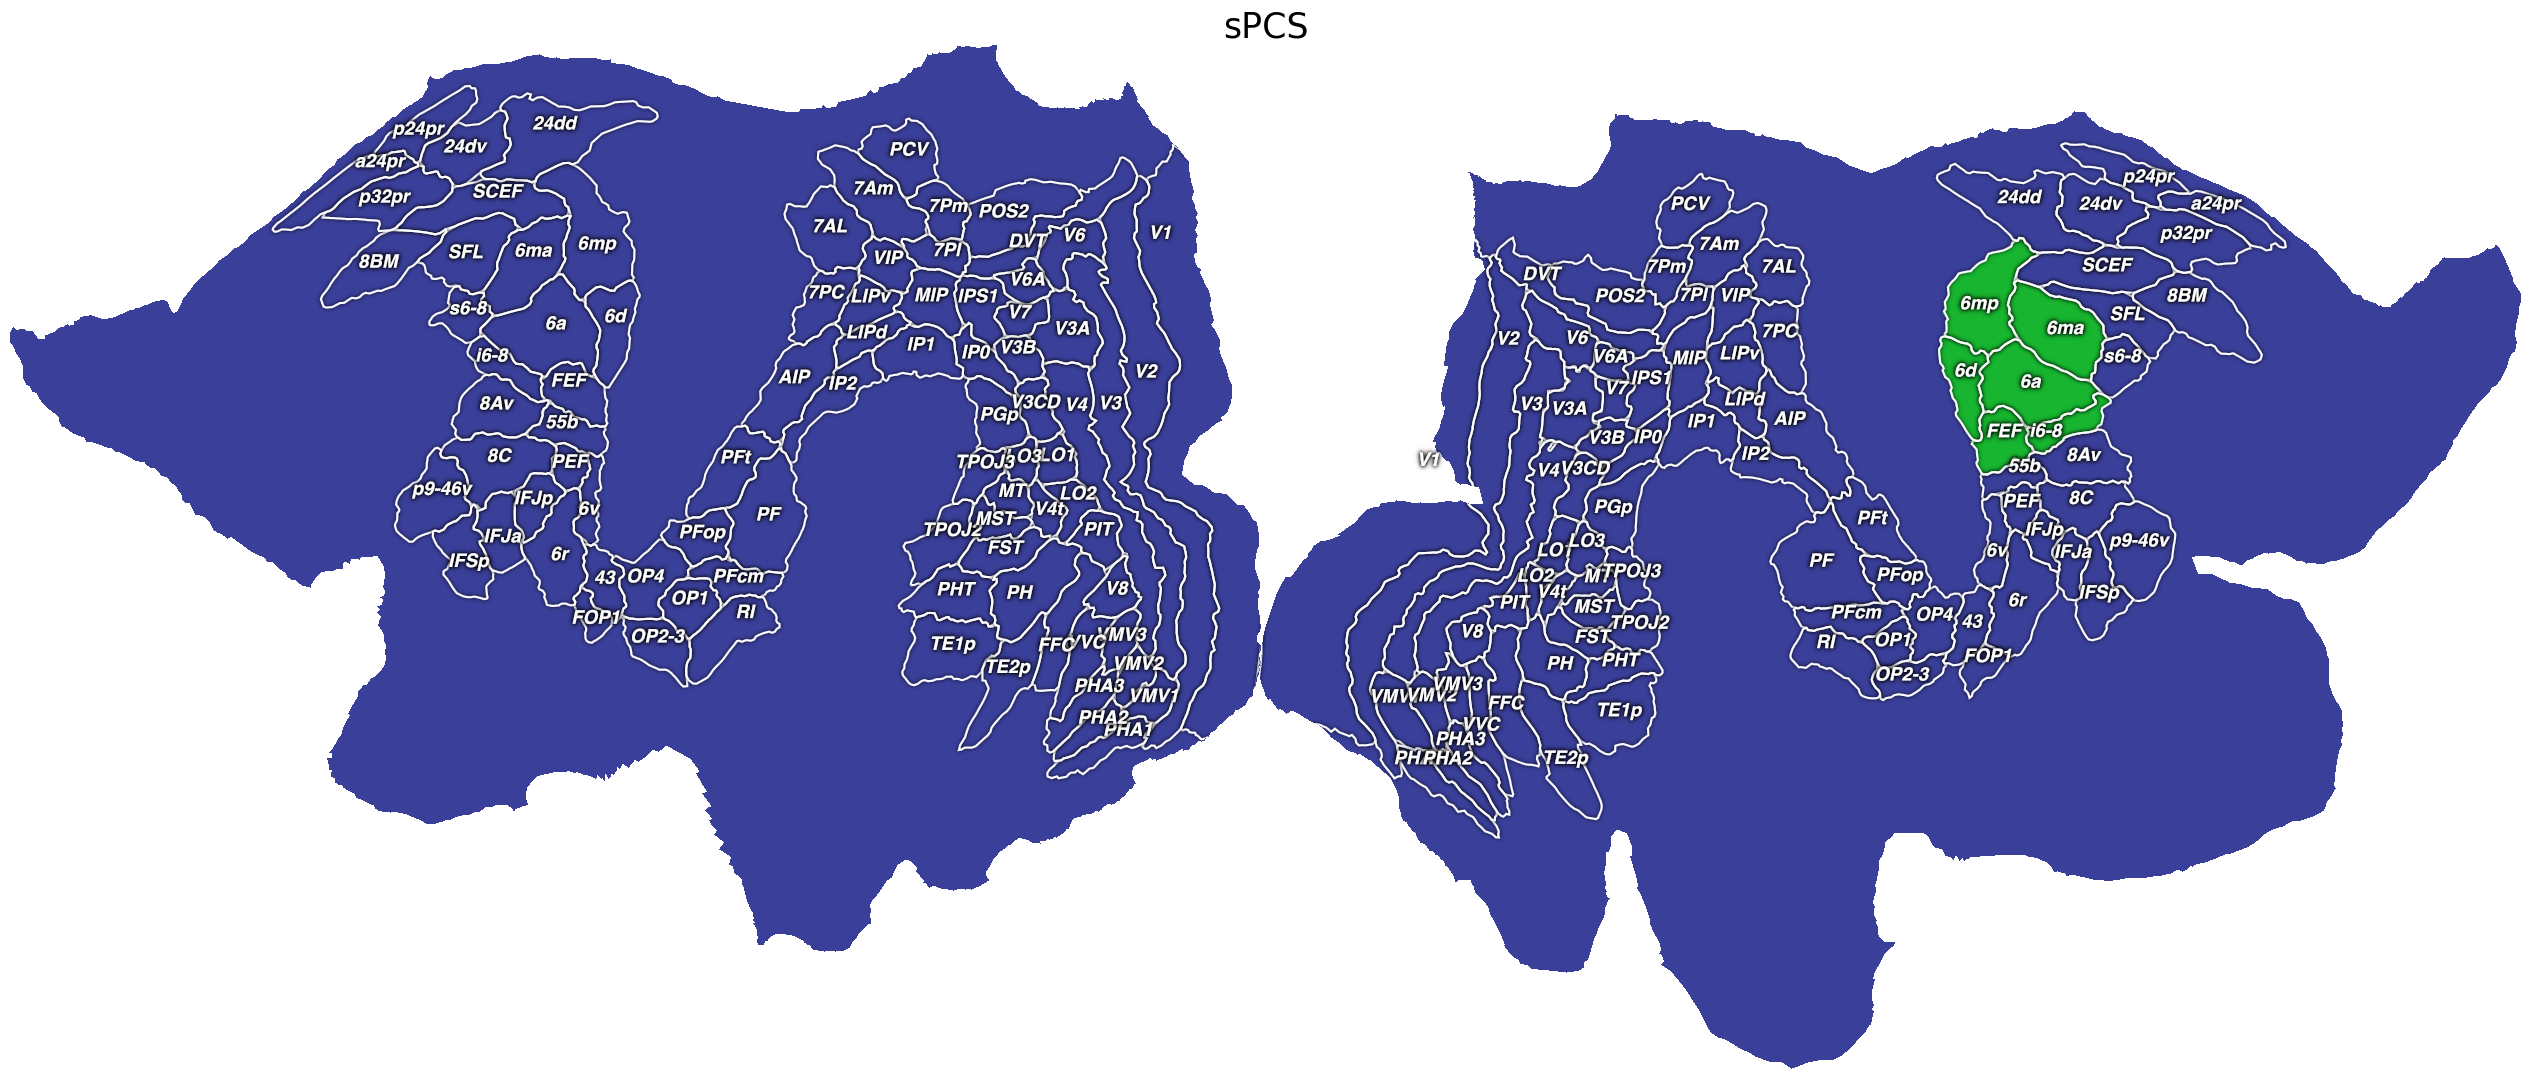

In [26]:
# Make verification with replot areas 
roi_name = 'sPCS'
pycortex_subject = 'sub-170k'
roi_data = np.array((rois_dict_170k_group_R[roi_name] == True).astype(np.int32)).reshape((1, rois_dict_170k_group_R[roi_name].shape[0]))

results = from_170k_to_59k(img=img_170k, data=roi_data, return_concat_hemis=True, return_59k_mask=False)
roi_data_59k = results['data_concat']

vertex_data = cortex.Vertex(roi_data_59k[0,:], pycortex_subject, cmap='BROYG', vmin=0, vmax=1)
cortex.quickshow(vertex_data, with_colorbar=False)
plt.title('{}'.format(roi_name),fontsize=25)
plt.show()

In [39]:
for roi_mmp, roi in zip(analysis_info['mmp_rois'], analysis_info['rois']):
    print(roi_mmp, roi)

In [45]:
concat_rois_list = [analysis_info['mmp_rois'], analysis_info['rois']]

In [47]:
for n_list, rois_list in enumerate(concat_rois_list):
    rois = rois_list
    if 'LO' in rois_list:
        print('mmp_grop')
#     else :
#         print('mmp')

mmp_grop


In [44]:
rois

['V1',
 'V2',
 'V3',
 'V3AB',
 'LO',
 'VO',
 'hMT+',
 'iIPS',
 'sIPS',
 'iPCS',
 'sPCS',
 'mPCS']